<a href="https://colab.research.google.com/github/youcancallme/sdu-deeplearning-cifar-10/blob/main/CIFAR-10-v5-changeTrain-numbatch%3D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初始化

## 本地实现

首先进行的是文件读取

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## torchvision实现

上面是我自己对数据的处理，其实torchvision提供了对cifar-10数据集的处理，并且提供了及其方便的预处理代码

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

### 数据增强

图像增广，训练集进行增广，测试时标准化执行

In [3]:
#已经解压的数据集路径
#本地
# unzip_folder_path='../cifar-10-python'
#colab
unzip_folder_path= '/content/drive/MyDrive/cifar-10-python'

In [4]:
#训练集
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),ratio=(1.0, 1.0)),
    #以 50% 的概率对输入图像进行水平翻转,用于数据增强。
    torchvision.transforms.RandomHorizontalFlip(),
    # NumPy 数组转换为 PyTorch Tensor 。
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道 三通道分别归一化，到均值为 0、标准差为 1 的分布。
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

#测试集
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [5]:
#如果不使用数据增广的话，只将数据变为tensor和标准化
transform= torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])


In [6]:
#训练集 train=True加载训练集
trainset = torchvision.datasets.CIFAR10(root=unzip_folder_path, train=True,
                                        download=False, transform=transform_train)

#测试集
testset = torchvision.datasets.CIFAR10(root=unzip_folder_path, train=False,
                                       download=False, transform=transform_test)

In [7]:
image, label = trainset[0]
image_size = image.size()
image_size

torch.Size([3, 32, 32])

### 创建数据加载器

DataLoader将数据集转换为可迭代的数据加载器对象。
batch_size参数指定每个批次中的样本数量。
shuffle=True表示在每个时期(epoch)开始时对数据进行洗牌。
num_workers参数指定用于数据加载的线程数
但是这里没用到啊，只有在kfold哪里用到了，而且test的还没有进行验证

In [ ]:
# #训练集  batch_size=128  shuffle=True打乱数据  num_workers=2使用两个进程加载数据
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
#                                           shuffle=True, num_workers=2)

# #测试集 batch_size=128  shuffle=False不打乱数据  num_workers=2使用两个进程加载数据
# testloader = torch.utils.data.DataLoader(testset, batch_size=128,
#                                          shuffle=False, num_workers=2)

## 1折交叉验证

使用KFold类从sklearn.model_selection库中创建了一个1折交叉验证对象。n_splits参数设置为10，表示将数据集划分为10个折（10份），shuffle=True表示在划分前对数据进行洗牌。

In [8]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)

In [9]:
# argmax 函数别名定义了一个匿名函数，它接受参数 x，并调用 x.argmax(*args, **kwargs) 方法。
# astype 函数别名定义了一个匿名函数，它接受参数 x，并调用 x.type(*args, **kwargs) 方法。
# reduce_sum 函数别名定义了一个匿名函数，它接受参数 x，并调用 x.sum(*args, **kwargs) 方法。

argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
def accuracy(y_hat, y):
    #首先处理y_hat形状，如果 y_hat 的维度大于1且最后一个维度大于1,则说明 y_hat 是一个包含多个类别概率的tensor。
    #这种情况下,需要使用 argmax 函数找出每个样本预测概率最高的类别索引,赋值给 y_hat。
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
  #使用astype函数将y_hat的数据类型转换为和y相同的类型,方便比较
  #比较是否相等，如果相等就得到布尔类型的tensor
    cmp = astype(y_hat, y.dtype) == y
  #使用 reduce_sum 函数统计 cmp 中为True的元素个数,得到预测正确的样本数
    return float(reduce_sum(astype(cmp, y.dtype)))
# def accuracy(y_hat, y):
#     """Compute the number of correct predictions."""
#     if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
#         y_hat = y_hat.argmax(dim=1)
#     cmp = y_hat.type(y.dtype) == y
#     return float(cmp.type(y.dtype).sum())

In [10]:
def train_batch(net, X, y, loss, trainer, devices):
    # 转移到一个device上
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    #训练
    net.train()
    #梯度为0
    trainer.zero_grad()
    #前向传播
    pred = net(X)
    #计算损失
    l = loss(pred, y)
    #反向传播更新参数
    l.sum().backward()
    trainer.step()

    #本批次的损失和准确度
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum


In [27]:
def k_fold(net, criterion, lr_period, lr_decay, lr, wd, trainset, devices, num_epochs=1, batch_size=128):
    # 使用 KFold 进行 10 折交叉验证，shuffle=True 表示打乱数据集
    kfold = KFold(n_splits=10, shuffle=True)

    # for epoch in range(num_epochs):
        # 一折交叉验证
    for fold, (train_indices, val_indices) in enumerate(kfold.split(trainset)):
        print(f'Fold {fold+1}')

        trainset_fold = torch.utils.data.Subset(trainset, train_indices)  # 获取当前折的训练集
        valset_fold = torch.utils.data.Subset(trainset, val_indices)  # 获取当前折的验证集

        #当前折训练数据集
        trainloader_fold = torch.utils.data.DataLoader(trainset_fold, batch_size=batch_size, shuffle=True, num_workers=2)
        #当前折验证数据集
        valloader_fold = torch.utils.data.DataLoader(valset_fold, batch_size=batch_size, shuffle=False, num_workers=2)

        # 为每一折创建一个新的网络实例
        model = nn.DataParallel(net, device_ids=devices).to(devices[0])

          # sgd优化器
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
        #学习率调度器，
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)

        for epoch in range(num_epochs):


            #running_loss 用于记录整个训练过程中的累积损失值。
            running_loss = 0.0
            model.train()

            #循环训练集的特征和标签
            for i, (inputs, labels) in enumerate(trainloader_fold):
              #计算每个批次的损失和返回预测正确的样本数，
              #net 特征 标签 损失函数 sgd优化器 设备
                loss, acc = train_batch(model, inputs, labels, criterion, optimizer, devices)
                #用正确的样本数/当前batch的总样本数即可
                Acc=float(acc) / labels.shape[0]

              #将当前批次的损失值 loss 加到 running_loss 变量中。
                running_loss += loss.item()
              #检查当前批次的索引是否为训练数据批次总数的 1/5 倍,或者是否为最后一个批次。
                if (i + 1) % (len(trainloader_fold) // 5) == 0 or i == len(trainloader_fold) - 1:
                  #当前batch的索引和总batch数量，当前的平均损失，当前的准确率
                    print(f'Epoch [{epoch+1}/{num_epochs}]，Batch [{i+1}/{len(trainloader_fold)}], Loss: {running_loss / (i + 1):.4f}, Acc: {Acc:.2f}')

            scheduler.step()

        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0

            for inputs, labels in valloader_fold:
                inputs = inputs.to(devices[0])
                labels = labels.to(devices[0])

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print(f'Validation Accuracy: {accuracy:.2f}%')

      # 绘制损失、训练集正确率和验证集正确率
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 2)
    plt.plot(train_accs)
    plt.title('Training Accuracy')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(val_accs)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

## ResNet模型

残差块

In [12]:
from torch.nn import functional as F
#画图表示
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        #初始化
        super().__init__()
        #两个卷积层，内核大小都为3，
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        #输入通道为上一层的输出通道
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:#如果不使用的话，在应用Relu前，将输入添加到输出；如果使用，通过添加1×1卷积来调整通道和分辨率
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        #两个批量归一化层
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [13]:
def resnet18(num_classes, in_channels=1):

    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    Residual(in_channels, out_channels, use_1x1conv=True,
                                 strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    #不可以删掉最大池化层，可能会使梯度消失，使网络的感受野减小
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module("fc",
                   nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

In [14]:
def get_net():
    num_classes = 10
    net = resnet18(num_classes, 3)
    return net

criterion = nn.CrossEntropyLoss(reduction="none")

In [15]:
X = torch.rand(size=(4, 3, 32, 32))
net=get_net()
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([4, 64, 32, 32])
BatchNorm2d output shape:	 torch.Size([4, 64, 32, 32])
ReLU output shape:	 torch.Size([4, 64, 32, 32])
MaxPool2d output shape:	 torch.Size([4, 64, 16, 16])
Sequential output shape:	 torch.Size([4, 64, 16, 16])
Sequential output shape:	 torch.Size([4, 128, 8, 8])
Sequential output shape:	 torch.Size([4, 256, 4, 4])
Sequential output shape:	 torch.Size([4, 512, 2, 2])
AdaptiveAvgPool2d output shape:	 torch.Size([4, 512, 1, 1])
Sequential output shape:	 torch.Size([4, 10])


In [25]:
!pip install matplotlib

In [26]:
import matplotlib.pyplot as plt

In [16]:
def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [
        torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

Fold 1
Epoch [1/1]，Batch [70/352], Loss: 243.8685, Acc: 0.35
Epoch [1/1]，Batch [140/352], Loss: 223.1347, Acc: 0.36
Epoch [1/1]，Batch [210/352], Loss: 210.9637, Acc: 0.44
Epoch [1/1]，Batch [280/352], Loss: 202.3430, Acc: 0.50
Epoch [1/1]，Batch [350/352], Loss: 194.6184, Acc: 0.55
Epoch [1/1]，Batch [352/352], Loss: 194.1608, Acc: 0.58
Validation Accuracy: 52.24%
Fold 2
Epoch [1/1]，Batch [70/352], Loss: 152.5094, Acc: 0.57
Epoch [1/1]，Batch [140/352], Loss: 150.3627, Acc: 0.61
Epoch [1/1]，Batch [210/352], Loss: 148.2907, Acc: 0.58
Epoch [1/1]，Batch [280/352], Loss: 144.9788, Acc: 0.62
Epoch [1/1]，Batch [350/352], Loss: 142.4782, Acc: 0.59
Epoch [1/1]，Batch [352/352], Loss: 142.1794, Acc: 0.67
Validation Accuracy: 64.86%
Fold 3
Epoch [1/1]，Batch [70/352], Loss: 123.7064, Acc: 0.67
Epoch [1/1]，Batch [140/352], Loss: 121.7337, Acc: 0.66
Epoch [1/1]，Batch [210/352], Loss: 120.1795, Acc: 0.66
Epoch [1/1]，Batch [280/352], Loss: 119.2716, Acc: 0.66
Epoch [1/1]，Batch [350/352], Loss: 117.4753, A

NameError: name 'train_losses' is not defined

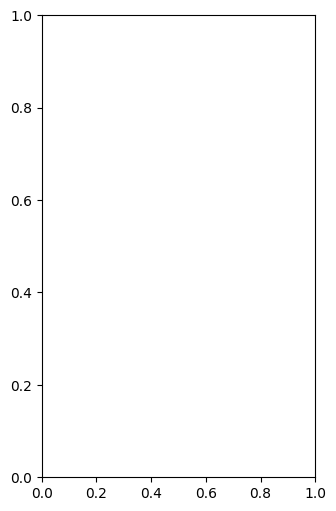

In [28]:
# 使用示例
device,num_epochs, lr, wd =try_all_gpus(),20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
# train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)
k_fold(net, criterion, lr_period, lr_decay, lr, wd, trainset,device)